<a href="https://colab.research.google.com/github/Orwell2002/trabalhoJPEG/blob/main/TrabalhoJPEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final - Processamento de sinais
Insituto Federal de Minas Gerais - IFMG - Campus Betim

Gabriel Keven Domingues de Souza - RA: 0056232

Victor Hugo Bittencourt - RA: 0055966

# Introdução
A crescente demanda na transmissão e compartilhamento de mídias, bem como a evolução na captura de imagens e vídeos, que tem como consequência arquivos cada vez maiores, fez com que o processamento desses dados se tornasse essencial.
O objetivo do presente trabalho será diminuir desenvolver um algoritmo de compressão de imagem, usando o formato jpeg, a fim de diminuir consideravelmente o tamanho de uma imagem.

O processo de compressão de imagens pode ser dividido nas etapas abaixo:

1. Conversão de RGB para YCrCb;

1. Chroma Subsampling;

1. DCT(Transformada Discreta do Cosseno);

1. Quantização;

1. Codificação de Huffman;

1. Transformação para arquivo JPEG.

Para obter uma visão geral do processo de compactação de imagens <a href='<https://www.youtube.com/watch?v=0me3guauqOU>'>Clique aqui</a>


In [ ]:
!pip install BitStream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 163 kB 15.3 MB/s 
  Created wheel for BitStream: filename=bitstream-2.6.0.2-cp38-cp38-linux_x86_64.whl size=573103 sha256=2e7a5a9c6581cdbcc82c344d46d6f01293a53bb06397d75e4725a9d103c993b9
  Stored in directory: /root/.cache/pip/wheels/0d/b5/9f/2949c526f59dcefa1362cc8d28de97353e78bad0952ec3c8f8
Successfully built BitStream


In [ ]:
# Importação das bibliotecas
import numpy as np, scipy as sp, matplotlib.pyplot as plt, IPython.display as ipd, pandas as pd, matplotlib.colors as cls, requests,scipy.fftpack
from scipy.io import wavfile
from scipy.fftpack import dct
from scipy.fftpack import idct
from bitstream import BitStream
from scipy import signal
from PIL import Image
from matplotlib.colors import Normalize
import ipywidgets as widgets
import matplotlib.cm as cm
import requests
import cv2
import os

huffmanRequest = requests.get('https://raw.githubusercontent.com/fangwei123456/python-jpeg-encoder/d92dcf7718543d9f09c0df43bb7df2e6ada76394/huffmanEncode.py');
open("huffman.py", "wb").write(huffmanRequest.content);
exec(open('huffman.py').read())

import huffman            # Importar codificador de Huffman do GitHub

In [ ]:
# Arquivos de imagem para compressão

# Compressão
exemplo = requests.get('https://raw.githubusercontent.com/Orwell2002/trabalhoJPEG/main/exemplo.bmp');
ifmg = requests.get('https://raw.githubusercontent.com/Orwell2002/trabalhoJPEG/main/if.bmp');
r = requests.get('https://raw.githubusercontent.com/Orwell2002/trabalhoJPEG/main/r.bmp');
rgb = requests.get('https://raw.githubusercontent.com/Orwell2002/trabalhoJPEG/main/rgb.bmp');


# 1 - Conversão de RGB para YCrCb

Uma imagem é composta por pixels, nos quais são dispostos em linhas e colunas semelhante a um retângulo. O pixel é formado por três componentes: RGB, que significam respectivamente vermelho(**R**ed), verde(**G**reen) e azul(**B**lue).
Cada um destes componentes possui um range, isto, é um intervalo de valores de 0 a 255. Em que *0* seria o menor valor e *255* seria o valor máximo.

O primeiro passo para compactar um imagem do tipo JPEG é converter RGB em YCbCr.
Y: Luminância(Luminance)
Cb: Crominâcia Azul(Blue Chrominance)
Cr: Crominância Vermelha(Red Chrominace)

Luminância significa o brilho geral do pixel. Quanto maior a luminânica, mais brilho terá aquele pixel. Por sua vez, crominância azul e vermelha são respectivamente a indicação da 'quantidade' de azul e vermelho naquele pixel. 

Abaixo está o código que representa cada componente RGB da imagem:

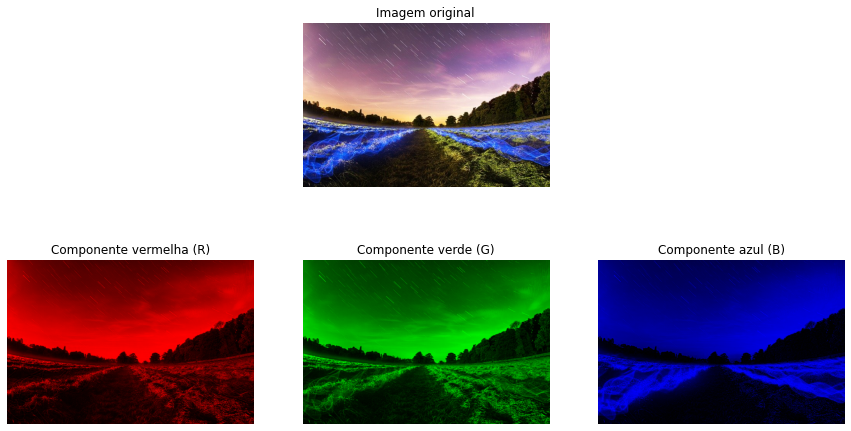

In [ ]:
open("img.bmp", "wb").write(exemplo.content);
img = plt.imread('img.bmp')

alturaImagem, larguraImagem = len(img),len(img[0])

red = np.full((alturaImagem, larguraImagem, 3), [1,0,0])               # cria matriz imagem com tamanho altura x largura, com 1 na componente r e 0 nas demais
green = np.full((alturaImagem, larguraImagem, 3), [0,1,0])
blue = np.full((alturaImagem, larguraImagem, 3), [0,0,1])

imgR = img*red                                             # multiplica pela matriz red, zerando as outras componentes
imgG = img*green
imgB = img*blue

plt.figure(figsize=(15,8))
plt.subplot(2,3,2)
plt.title('Imagem original')
plt.axis('off')
plt.imshow(img)
plt.subplot(2,3,4)
plt.title('Componente vermelha (R)')
plt.axis('off')
plt.imshow(imgR)
plt.subplot(2,3,5)
plt.title('Componente verde (G)')
plt.axis('off')
plt.imshow(imgG)
plt.subplot(2,3,6)
plt.title('Componente azul (B)')
plt.axis('off')
plt.imshow(imgB);

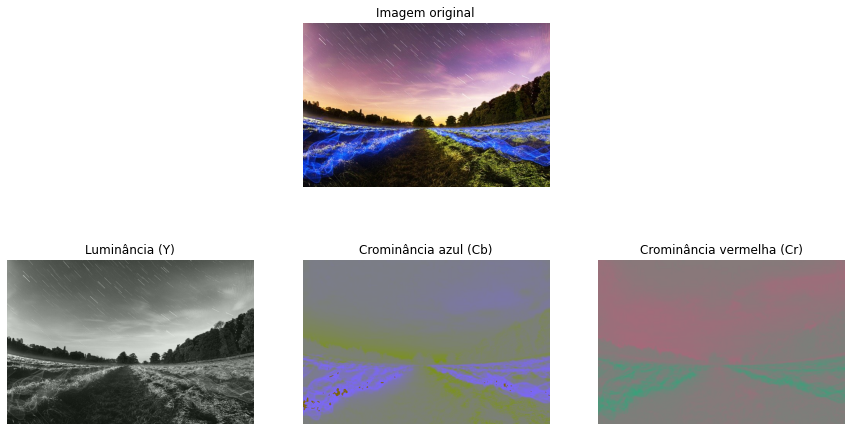

In [ ]:
#Convertendo RGB para YCbCr

def RGBparaYCbCr (img):

  altura, largura = len(img),len(img[0]) 

  y = np.full((altura, largura, 3), [1,0,0])
  cb = np.full((altura, largura, 3), [0,1,0])
  cr = np.full((altura, largura, 3), [0,0,1])

  imgR = img[:,:,0]   # Somente a componete R da imagem 
  imgG = img[:,:,1]   # Somente a componete G da imagem
  imgB = img[:,:,2]   # Somente a componete B da imagem
 
  imgY  = 16  + 0.256789063*imgR + 0.504128906*imgG + 0.09790625*imgB
  imgCb = 128 - 0.148222656*imgR - 0.290992188*imgG + 0.439214844*imgB
  imgCr = 128 + 0.439214844*imgR - 0.367789063*imgG - 0.0714257813*imgB

  return np.stack((imgY,imgCb,imgCr),axis=2).astype(int)             # np.stack junta os arrays de volta em 2 eixos, é necessário transformar o vetor em inteiro (unsigned int de 8 bits é o suficiente)
  

def YCbCrparaRGB (img):

  img = img.astype(float)                                             # É necessário converter a imagem para float, se n as contas posteriores serão arredondadas para inteiros e distorecerá a imagem
  altura, largura = len(img),len(img[0])

  r = np.full((altura, largura, 3), [1,0,0])
  g = np.full((altura, largura, 3), [0,1,0])
  b = np.full((altura, largura, 3), [0,0,1])

  imgY  = img[:,:,0]  
  imgCb = img[:,:,1]
  imgCr = img[:,:,2]

  imgR = imgY + 1.402*(imgCr - 128)
  imgG = imgY - 0.344136*(imgCb - 128) - 0.714136*(imgCr - 128)
  imgB = imgY + 1.772*(imgCb-128)

  return np.stack((imgR,imgG,imgB),axis=2).astype(int)

imgYCbCr = RGBparaYCbCr(img)
imgRGB = YCbCrparaRGB(imgYCbCr)

imgY_ = imgYCbCr[:,:,0]
imgCb_ = imgYCbCr[:,:,1]
imgCr_ = imgYCbCr[:,:,2]

imgY = (red*(imgY_.reshape(alturaImagem,larguraImagem,1))) + np.full((alturaImagem, larguraImagem, 3), [0,126,126])
imgCb = (green*(imgCb_.reshape(alturaImagem,larguraImagem,1))) + np.full((alturaImagem, larguraImagem, 3), [126,0,126])
imgCr = (blue*(imgCr_.reshape(alturaImagem,larguraImagem,1))) + np.full((alturaImagem, larguraImagem, 3), [126,126,0])
imgY = YCbCrparaRGB(imgY).astype(np.uint8)
imgCb = YCbCrparaRGB(imgCb).astype(np.uint8)
imgCr = YCbCrparaRGB(imgCr).astype(np.uint8)

plt.figure(figsize=(15,8))
plt.subplot(2,3,2)
plt.title('Imagem original')
plt.axis('off')
plt.imshow(img)
plt.subplot(2,3,4)
plt.title('Luminância (Y)')
plt.axis('off')
plt.imshow(imgY)
plt.subplot(2,3,5)
plt.title('Crominância azul (Cb)')
plt.axis('off')
plt.imshow(imgCb)
plt.subplot(2,3,6)
plt.title('Crominância vermelha (Cr)')
plt.axis('off')
plt.imshow(imgCr);

# 2 - Chroma subsampling 4:2:0
O olho humano é mais sensível a variação de luminância do que as cores. Assim, antes de realizar o processo de subamostragem das cores (Chroma subsampling) é preciso transformar a imagem para YCrCb. Tudo isso, para que o procedimento de subamostragem seja feito somente na crominância azul e vermelha.

O processo de subamostagem consiste em diminuir o número de amostras de um conjunto de dados de acordo com um determinado fator.

Para o chroma subsampling 4:2:0, 4 indica que todas as informações da luminância estão mantidas. *2* detalha que apenas 2 pixels da linha superior são mantidos do bloco original e que seus pixels adjacentes recebem respectivamente suas cores conforme abaixo. 

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/Croma1.png' width=300px>
<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/croma2.png' width=300px>

Por sua vez, *0* diz que não há informação de cor na linha de baixo. Assim as cores da linha superior são copiados para a linha abaixo, conforme imagem a seguir. 

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/croma3.png' width=300px>

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/croma4.png' width=300px>

Este procedimento reduz em 25% a quantidade de cores da imagem.


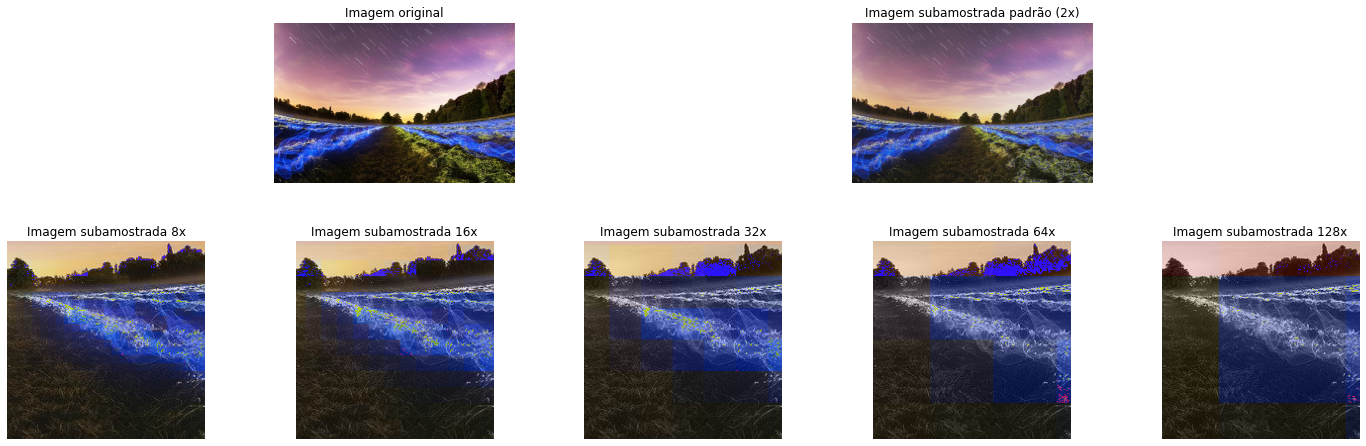

In [ ]:
def subamostragem (img,sub = 2):

  # 4:2:0

  altura, largura = len(img),len(img[0])
  imgYCbCr = RGBparaYCbCr(img)

  imgY = imgYCbCr[:,:,0]
  imgCb = imgYCbCr[:,:,1]
  imgCr = imgYCbCr[:,:,2]

  matrizCb = np.zeros((altura,largura))                     # Cria vetor do mesmo tamanho da imagem, porém zerado
  matrizCr = np.zeros((altura,largura)) 

  for i in range(0, altura, sub):                           # for percorre a imagem de 2 em 2
    for j in range(0, largura, sub):
      matrizCb[i:i+sub, j:j+sub] = np.mean(imgCb[i:i+sub, j:j+sub])   # Atribui aos pixels o valor da média de seu bloco 2x2
      matrizCr[i:i+sub, j:j+sub] = np.mean(imgCr[i:i+sub, j:j+sub]) 

  imgSubYCbCr = np.stack((imgY_,matrizCb,matrizCr),axis=2)
  imgSub = YCbCrparaRGB(imgSubYCbCr).astype(np.uint8)

  return np.round(imgSub).astype('uint8')

# Luminância não é subamostrada

imgSub = subamostragem(img,2)
imgSub8 = subamostragem(img,8)
imgSub16 = subamostragem(img,16)
imgSub32 = subamostragem(img,32)
imgSub64 = subamostragem(img,64)
imgSub128 = subamostragem(img,128)

plt.figure(figsize=(25,8))
plt.subplot(2,5,2)
plt.title('Imagem original')
plt.axis('off')
plt.imshow(img)
plt.subplot(2,5,4)
plt.title('Imagem subamostrada padrão (2x)')
plt.axis('off')
plt.imshow(imgSub)
plt.subplot(2,5,6)
plt.title('Imagem subamostrada 8x')
plt.axis('off')
plt.xlim(313,113)
plt.ylim(420,220)
plt.imshow(imgSub8)
plt.subplot(2,5,7)
plt.title('Imagem subamostrada 16x')
plt.axis('off')
plt.xlim(313,113)
plt.ylim(420,220)
plt.imshow(imgSub16)
plt.subplot(2,5,8)
plt.title('Imagem subamostrada 32x')
plt.axis('off')
plt.xlim(313,113)
plt.ylim(420,220)
plt.imshow(imgSub32)
plt.subplot(2,5,9)
plt.title('Imagem subamostrada 64x')
plt.axis('off')
plt.xlim(313,113)
plt.ylim(420,220)
plt.imshow(imgSub64)
plt.subplot(2,5,10)
plt.title('Imagem subamostrada 128x')
plt.axis('off')
plt.xlim(313,113)
plt.ylim(420,220)
plt.imshow(imgSub128);

# 3 - Transformada Discreta do Cosseno

A transformada discreta do cosseno (DCT) consiste em um processo sem perdas e reversível. Em síntese, a DCT consiste basicamente em converter os valores dos pixels em coeficientes respresentando frequências espaciais.

Para realizar a DCT, a imagem é subdivida em blocos de 8x8 pixels. Esta divisão se faz necessária a fim de amenizar o processamento computacional.

Após aplicar a transformada na imagem subamostrada, são obtidos os coeficientes da DCT, em que os valores negativos ou próximos a zeros podem ser desprezados. Em consequência disso, há possiblidade de economia de bits.

Vale ressaltar que os coeficientes da DCT são sempre números reais. E que para compressão de vídeos e imagens utiliza-se a transformada bidimensional.

Fórmula da transformada bidimensional DCT:

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/formula_dct.png'>

Esta formula se aplica a uma imagem **p** de tamanho n x n

Fórmula da transformada inversa bidimensional (IDCT):

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/formula_idct.png'>


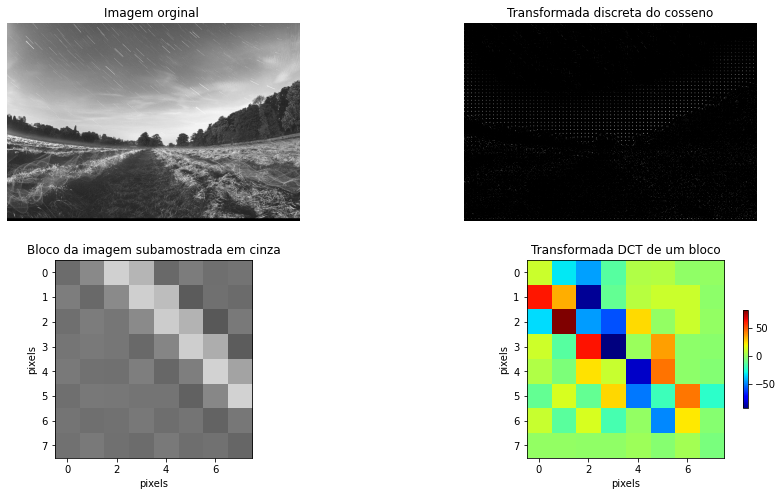

In [ ]:
# Obtendo a imagem subamostrada
imgSubYCbCr = RGBparaYCbCr(imgSub)
imgYSub = imgSubYCbCr[:,:,0]
imgCbSub = imgSubYCbCr[:,:,1]
imgCrSub = imgSubYCbCr[:,:,2]

# Definição do tamanho do bloco
T = 8

# Transformar matriz em matriz com altura e largura múltipla de 8
larguraMultipla = larguraImagem
alturaMultipla = alturaImagem

if (larguraImagem % 8 != 0):
  larguraMultipla = larguraImagem // 8 * 8 + 8    # Se largura não for dividivel por 8, substitui-se pelo múltiplo mais próximo
if (alturaImagem % 8 != 0):
  alturaMultipla = alturaImagem // 8 * 8 + 8

larguraImagem   = int(larguraImagem)
alturaImagem    = int(alturaImagem)
larguraMultipla = int(larguraMultipla)
alturaMultipla  = int(alturaMultipla)

matrizMultiplaY = np.zeros((alturaMultipla,larguraMultipla), dtype=np.uint8)
matrizMultiplaCb = np.zeros((alturaMultipla,larguraMultipla), dtype=np.uint8)
matrizMultiplaCr = np.zeros((alturaMultipla,larguraMultipla), dtype=np.uint8)   # Criar vetor zerado com tamanho multiplo de 8
for y in range(alturaImagem):
  for x in range(larguraImagem):
    matrizMultiplaY[y][x] = imgYSub[y][x]
    matrizMultiplaCb[y][x] = imgCbSub[y][x]
    matrizMultiplaCr[y][x] = imgCrSub[y][x]

# Transformação da imagem para tons de cinza
imgSubY = matrizMultiplaY
imgSubCb = matrizMultiplaCb
imgSubCr = matrizMultiplaCr

imgSubY=imgSubY[:alturaMultipla,:larguraMultipla]
imgSubCb=imgSubCb[:alturaMultipla,:larguraMultipla]
imgSubCr=imgSubCr[:alturaMultipla,:larguraMultipla]

# Coeficientes da transformada 
transformadaY = np.zeros((alturaMultipla,larguraMultipla),np.float32)
transformadaCr = np.zeros((alturaMultipla,larguraMultipla),np.float32)
transformadaCb = np.zeros((alturaMultipla,larguraMultipla),np.float32)

vis0 = np.asarray(imgSubY).astype(int)
vis1 = np.asarray(imgSubCb).astype(int)
vis2 = np.asarray(imgSubCr).astype(int)

vis0 = vis0 - 127
vis1 = vis1 - 127
vis2 = vis2 - 127


for linha in range(0,alturaMultipla,8):
  for coluna in range(0,larguraMultipla,8):
     blocoAtualY = dct(dct(vis0[linha:linha + 8, coluna:coluna + 8],  norm='ortho').T,  norm='ortho').T
     transformadaY[linha:linha + 8, coluna:coluna + 8] = blocoAtualY
     blocoAtualCb = dct(dct(vis1[linha:linha + 8, coluna:coluna + 8], axis=0, norm='ortho'), axis=1, norm='ortho')
     transformadaCb[linha:linha + 8, coluna:coluna + 8] = blocoAtualCb
     blocoAtualCr = dct(dct(vis2[linha:linha + 8, coluna:coluna + 8], axis=0, norm='ortho'), axis=1, norm='ortho')
     transformadaCr[linha:linha + 8, coluna:coluna + 8] = blocoAtualCr

# Coeficientes da transformada inversa 
inversaY = np.zeros((alturaMultipla,larguraMultipla), np.float32) 
inversaCb = np.zeros((alturaMultipla,larguraMultipla), np.float32) 
inversaCr = np.zeros((alturaMultipla,larguraMultipla), np.float32) 

for linha in range(0,alturaMultipla,8): 
  for coluna in range(0,larguraMultipla,8): 
    blocoAtualY = idct(idct(vis0[linha:linha + 8, coluna:coluna + 8], norm='ortho').T, norm='ortho').T
    inversaY[linha:linha + 8, coluna:coluna + 8] = blocoAtualY
    blocoAtualCb = idct(idct(vis1[linha:linha + 8, coluna:coluna + 8], norm='ortho').T, norm='ortho').T
    inversaCb[linha:linha + 8, coluna:coluna + 8] = blocoAtualCb
    blocoAtualCr = idct(idct(vis2[linha:linha + 8, coluna:coluna + 8], norm='ortho').T, norm='ortho').T
    inversaCr[linha:linha + 8, coluna:coluna + 8] = blocoAtualCr

# Exbindo os resultados da DCT na luminância

N255=Normalize(0,255) # Normalização de 0 a 255
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title('Imagem orginal ')
plt.axis('off')
plt.imshow(imgSubY,'gray')
plt.subplot(2,2,2)
plt.title('Transformada discreta do cosseno')
plt.axis('off')
plt.imshow(transformadaY,cmap="gray",norm=N255)

# Exbindo um bloco e a frequência deste bloco
plt.subplot(2,2,3)
plt.xlabel('pixels')
plt.ylabel('pixels')
xSelec, ySelec = [5,5]
imagemSelecionadaY=imgSubY[xSelec*8:(xSelec+1)*8,ySelec*8:(ySelec+1)*8]
plt.imshow(imagemSelecionadaY,cmap="gray",norm=N255,interpolation='nearest')
plt.title("Bloco da imagem subamostrada em cinza")

plt.subplot(2,2,4)
transformadaSelecionadaY=transformadaY[xSelec*8:(xSelec+1)*8,ySelec*8:(ySelec+1)*8]
plt.imshow(transformadaSelecionadaY,cmap=cm.jet,interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title("Transformada DCT de um bloco");

# 4 - Quantização

Após a obteção dos coeficientes da transformada discreta do cosseno(DCT), estes números serão quantizados por tabelas definidas pelo padrão JPEG. De acordo com a fórmula abaixo:

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/calculo_codificacao.png'>

Portanto, conforme a fórmula acima, a matriz de quantização significa a divisão de matriz da DCT com uma matriz pré definida pelo formato JPEG. A matriz resultante tem seus valores arrendondas para números inteiros. 

A tendência para a nova matriz resultante é que a maioria dos valores seja zero.


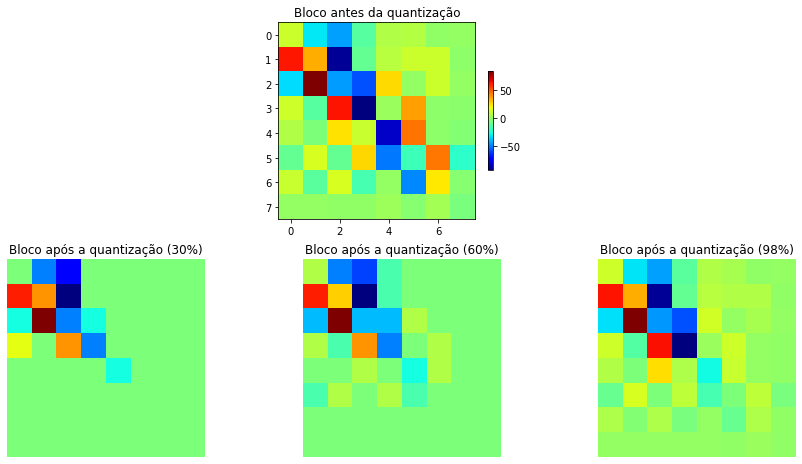

In [ ]:
# Matriz de Quantização
matrizY = np.array(
    [
        [16, 11, 10, 16, 24,  40,  51,  61], 
        [12, 12, 14, 19, 26,  58,  60,  55], 
        [14, 13, 16, 24, 40,  57,  69,  56], 
        [14, 17, 22, 29, 51,  87,  80,  62],
        [18, 22, 37, 56, 68,  109, 103, 77],
        [24, 35, 55, 64, 81,  104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ]
)

matrizCbCr = np.array(
    [
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
     ]
)

zigzag = np.array([0,1,8,16,9,2,3,10,17,24,32,25,18,11,4,5,12,19,26,33,40,48,41,34,27,
                  20,13,6,7,14,21,28,35,42,49,56,57,50,43,36,29,22,15,23,30,37,44,51,
                  58,59,52,45,38,31,39,46,53,60,61,54,47,55,62,63])

def quantizar(qualidade = 100, matrizes=False):

  # Ajuste da qualidade da imagem
  if(qualidade <= 0):
      qualidade = 1
  if(qualidade > 100):
      qualidade = 100
  if(qualidade < 50):
      escalaQualidade = 5000 / qualidade
  else:
      escalaQualidade = 200 - qualidade * 2
      
  novaMatrizY = np.array(np.floor((matrizY * escalaQualidade + 50) / 100))
  novaMatrizY[novaMatrizY == 0] = 1
  novaMatrizY[novaMatrizY > 255] = 255
  novaMatrizY = novaMatrizY.reshape([8, 8]).astype(int)

  novaMatrizCbCr = np.array(np.floor((matrizCbCr * escalaQualidade + 50) / 100))
  novaMatrizCbCr[novaMatrizCbCr == 0] = 1
  novaMatrizCbCr[novaMatrizCbCr > 255] = 255
  novaMatrizCbCr = novaMatrizCbCr.reshape([8, 8]).astype(int)

  transformadaQuantizadaY = np.zeros((alturaMultipla,larguraMultipla))
  transformadaQuantizadaCb = np.zeros((alturaMultipla,larguraMultipla))
  transformadaQuantizadaCr = np.zeros((alturaMultipla,larguraMultipla))

  # Definir as matrizes quantizadas (matriz/quantização)
  for linha in range(0,alturaMultipla,8):
    for coluna in range(0,larguraMultipla,8):
      quantizacaoAtualY = np.rint(transformadaY[linha:linha + 8, coluna:coluna + 8]/novaMatrizY)
      transformadaQuantizadaY[linha:linha + 8, coluna:coluna + 8] = (quantizacaoAtualY)
      quantizacaoAtualCb = np.rint(transformadaCb[linha:linha + 8, coluna:coluna + 8]/novaMatrizCbCr)
      transformadaQuantizadaCb[linha:linha + 8, coluna:coluna + 8] = (quantizacaoAtualCb)
      quantizacaoAtualCr = np.rint(transformadaCr[linha:linha + 8, coluna:coluna + 8]/novaMatrizCbCr)
      transformadaQuantizadaCr[linha:linha + 8, coluna:coluna + 8] = (quantizacaoAtualCr)

  if matrizes == False:
    return transformadaQuantizadaY,transformadaQuantizadaCb,transformadaQuantizadaCr
  if matrizes == True:
    return transformadaQuantizadaY,transformadaQuantizadaCb,transformadaQuantizadaCr,novaMatrizY,novaMatrizCbCr

transformadaQuantizadaY,transformadaQuantizadaCb,transformadaQuantizadaCr,novaMatrizY,novaMatrizCbCr = quantizar(98,matrizes=True)
quantY30,quantCb30,quantCr30 = quantizar(30)
quantY60,quantCb60,quantCr60 = quantizar(60)

# Exbindo blocos antes e após a quantização
plt.figure(figsize=(15,8))
plt.subplot(2,3,2)
transformadaSelecionadaY=transformadaY[xSelec*8:(xSelec+1)*8,ySelec*8:(ySelec+1)*8]
plt.imshow(transformadaSelecionadaY,cmap=cm.jet,interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title("Bloco antes da quantização");

plt.subplot(2,3,4)
transformadaSelecionadaY=quantY30[xSelec*8:(xSelec+1)*8,ySelec*8:(ySelec+1)*8]
plt.imshow(transformadaSelecionadaY,cmap=cm.jet,interpolation='nearest')
plt.axis('off')
plt.title("Bloco após a quantização (30%)");

plt.subplot(2,3,5)
transformadaSelecionadaY=quantY60[xSelec*8:(xSelec+1)*8,ySelec*8:(ySelec+1)*8]
plt.imshow(transformadaSelecionadaY,cmap=cm.jet,interpolation='nearest')
plt.axis('off')
plt.title("Bloco após a quantização (60%)");

plt.subplot(2,3,6)
transformadaSelecionadaY=transformadaQuantizadaY[xSelec*8:(xSelec+1)*8,ySelec*8:(ySelec+1)*8]
plt.imshow(transformadaSelecionadaY,cmap=cm.jet,interpolation='nearest')
plt.axis('off')
plt.title("Bloco após a quantização (98%)");

# 'Zig-Zag' nas matrizes quantizadas

matriz_zigzagY = []
matriz_zigzagCb = []
matriz_zigzagCr = []
for linha in range(0,alturaMultipla,8):
  for coluna in range(0,larguraMultipla,8):
    matriz8x8Y = transformadaQuantizadaY[linha:linha + 8, coluna:coluna + 8]
    matriz8x8Cb = transformadaQuantizadaCb[linha:linha + 8, coluna:coluna + 8]
    matriz8x8Cr = transformadaQuantizadaCr[linha:linha + 8, coluna:coluna + 8]
    # Matriz ZigZag de Luminância
    matriz_zigzagY.append(matriz8x8Y.reshape([64])[zigzag])
    # Matriz ZigZag de Cb
    matriz_zigzagCb.append(matriz8x8Cb.reshape([64])[zigzag])
    # Matriz ZigZag de Cr
    matriz_zigzagCr.append(matriz8x8Cr.reshape([64])[zigzag])

# 5 - Codificação de Huffman

O algoritmo de Huffman é utilizado para compressão de arquivos de texto sem perdas. Este algoritmo de compresão se baseia na ideia central de atribuir menos bits aos caracteres ou símbolos mais frequentes, isto é, mais redudantes. Em contrapartida, os códigos menos comuns recebem mais bits.

## Etapas básicas para codificação:

1. Atribuir as frequências de ocorrência dos caracteres ou símbolos no trecho a ser analisado;

1. Criar a árvore de codificação. Cada frequência atribuída anteriomente é representada por um nó. Os nós que possuem menor frquência são agrupados e reagrupados até o trecho analisado estar completamente vazio. 

1. Percorrer a árvore atribuindo 0 para a esquerda e 1 para a direita.

1. Codificar o trecho orginal de acordo com os bits definidos na varredura da árvore.

Exemplo de árvore de codificação:

<img src='https://raw.githubusercontent.com/Gabriel-Keven/trabalhoJPEG/main/Exemplo-arvore.png' width=600px>

Para o exemplo acima, a palavra *Ana*, seria escrita da seguinte forma:

*10010 101 11*. Tal representação permite uma economia de bits. Pois, cada caracter era orginalmente composto por 8 bits.

## Decodificação

Inicia-se a decoficação da árvore através da raíz. Se o bit for 0, a varredura será pela esquerda. Caso contrário, será pela direita. Ao encontrar uma folha, o conteúdo da mesma é resgatado para a construção do código orginal. Este procedimento se repete até a última folha.

Este algoritmo utiliza os conceitos de árvore. Em que, a probabilidade de ocorrência de um número, letra ou caracter é referenciada como uma folha desta árvore.

Este algoritmo foi desenvolvido por <a href='https://www.huffmancoding.com/my-uncle/scientific-american'>David A. Huffman.</a>

<img src='https://www.huffmancoding.com/wp-content/uploads/2008/12/dah.jpg' width='200px'>

Para mais detalhes deste algoritmo, <a href='https://www.youtube.com/watch?v=xQQt5myz00o'> clique aqui neste vídeo.</a>

In [ ]:
imgSubYCbCr = RGBparaYCbCr(imgSub)
imagemY,imagemCb,imagemCr = imgSubYCbCr[:,:,0],imgSubYCbCr[:,:,1],imgSubYCbCr[:,:,2]
    
matrizImagemY  = np.asarray(imagemY).astype(int)
matrizImagemCb = np.asarray(imagemCb).astype(int)
matrizImagemCr = np.asarray(imagemCr).astype(int)

matrizImagemY = matrizImagemY - 127
matrizImagemCb = matrizImagemCb - 127
matrizImagemCr = matrizImagemCr - 127

qtdBlocos = larguraMultipla // 8 * alturaMultipla // 8             # Quantidade de blocos

yDC   = np.zeros([qtdBlocos], dtype=int)
cbDC  = np.zeros([qtdBlocos], dtype=int)
crDC  = np.zeros([qtdBlocos], dtype=int)
dyDC  = np.zeros([qtdBlocos], dtype=int)
dcbDC = np.zeros([qtdBlocos], dtype=int)
dcrDC = np.zeros([qtdBlocos], dtype=int)
   
sosBitStream = BitStream()                                         # Imagem codificada através do codificador de Huffman (SOS = Start of Scan)
numBloco = 0                                                       # Número do bloco

for y in range(0, alturaMultipla, 8):
    for x in range(0, larguraMultipla, 8):
        yZCode = matriz_zigzagY[numBloco].astype(int)
        uZCode = matriz_zigzagCb[numBloco].astype(int)
        vZCode = matriz_zigzagCr[numBloco].astype(int)

        yDC[numBloco] = yZCode[0]
        cbDC[numBloco] = uZCode[0]
        crDC[numBloco] = vZCode[0]
        
        if(numBloco==0):
            dyDC[numBloco] = yDC[numBloco]
            dcbDC[numBloco] = cbDC[numBloco]
            dcrDC[numBloco] = crDC[numBloco]
        else:
            dyDC[numBloco] = yDC[numBloco] - yDC[numBloco-1]
            dcbDC[numBloco] = cbDC[numBloco] - cbDC[numBloco-1]
            dcrDC[numBloco] = crDC[numBloco] - crDC[numBloco-1]
            
        # codificar yDC
        sosBitStream.write(huffman.encodeDCToBoolList(dyDC[numBloco],1,0),bool)
        # codificar yAC
        huffman.encodeACBlock(sosBitStream, yZCode[1:], 1, 0)
        # codificar cbDC
        sosBitStream.write(huffman.encodeDCToBoolList(dcbDC[numBloco],0,0),bool)
        # codificar cbAC
        huffman.encodeACBlock(sosBitStream, uZCode[1:], 0, 0)
        # codificar crDC
        sosBitStream.write(huffman.encodeDCToBoolList(dcrDC[numBloco],0,0),bool)
        # codificar crAC
        huffman.encodeACBlock(sosBitStream, vZCode[1:], 0, 0)

        numBloco = numBloco + 1


# 6 - Transformação para arquivo JPEG
Para transformar a tabela dos valores de frequência codificados em um arquivo, é preciso escreve-la em um arquivo .jpg ou .jpeg, além de informar outros dados importantes para a decodificação da imagem, como as tabelas de quantização utilizadas, tamanho da imagem e a tabela de Huffman usada na codificação.

Esses valores serão escritos em formato de bytes para que possam ser entendidos e decodificados como arquivos jpeg por programas visualisadores de imagem, por exemplo.

<img src='https://d33wubrfki0l68.cloudfront.net/bdc1363abbd5744200ec5283d4154e55143df86c/8c624/images/decoding_jpeg/jpegrgb_dissected.png' width=80%>

Essas informações são escritas na seguinte ordem:

1. **SOI (Start of Image - Início da Imagem):** Cabeçalho JPEG, indica o início da imagem, bem como a versão JFIF - JPEG File Interchange Format - do arquivo, densidade de pixels, entre outras informações.

    `FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00`

    Sendo **FFDB** o marcador de inicio de imagem;

    **FFE0** o marcador APP0 (APPLICATION0, cabeçalho padrão para jpegs do tipo JFIF e AVI1);

    **0010** o tamanho de bytes do segmento em hexadecimal (10 = 16), excluindo o marcador de inicio e o de APPO;

    **4A46494600** o indentificador do formato (4A 46 49 46 00 = "JFIF" em ASCII);

    **0101** a versão do JFIF (1.01);

    **00** a unidade da densidade de pixels (no caso nenhuma, largura:altura em pixels);

    **00010001** a densidade de pixels horizontal e vertical, respectivamente (densidade 1 horizontal e 1 vertical);

    **0000** referente a contagem de pixels da miniatura, no caso 0 tanto pra X quanto para Y.

    O significado de cada byte pode ser encontrado em: https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format
    

2. **DQT (Define Quantization Table - Definir Tabela de Quantização):** Tabela de quantização da luminância (Y). Primeiramente é escrito o marcador da definição da tabela de quantização:

    `FF DB 00 43 00`

    Em que **FFDB** é o marcador, **0043** e o tamanho da variável em hexadecimal (43 = 67 bytes, 64 da tabela + 2 do tamanho + 1 do tipo) e **00** indica o tipo de tabela (0 = luminância / 1 = crominância)

    Depois disso é passada a tabela de quantização na forma de bytes.


3. **DQT (Define Quantization Table - Definir Tabela de Quantização):** Tabela de quantização da crominância (Cb e Cr). Assim como na definição da luminância, antes de passarmos a tabela precisamos esrever o marcador da definição da tabela de quantização da crominância:

    `FF DB 00 43 01`

    Nesse caso, o último byte do marcador será **01**, por se tratar da crominância e não da luminância.

    Em sequência, são passados os bytes da tabela de quantização.   


4. **SOF0 (Start of Frame - Começo do Quadro):** Existem dois tipos de SOF, o tipo *baseline* (SOF0), em que a imagem é carregada de baixo para cima, linha por linha, e o tipo *progressive* (SOF2), em que a imagem é mostrada de uma qualidade inferior até chegar na qualidade padrão. Além de indicar o tipo de "carregamento" da imagem na página, o SOF serve para informar a largura da imagem, altura, número de componentes e razão de subamostragem.

    `FF C0 00 11 08` 

    **FFC0** é o marcador de jpeg baseline, **0011** é o tamanho da variável e **08** é a precisão do arquivo.

    Apos isso são escritas a altura e largura em bytes.

    Por fim é escrita a quantidade de componentes, seguida do número de cada um e sua taxa de subamostragem:

    `03 01 11 00 02 11 01 03 11 01` = 3 componentes, a primeira tem fator de subamostragem 1x1 e é do tipo 0 (luminância Y), a segunda também tem fator de subamostragem 1x1 e é to tipo 1 (crominância Cb) e a terceira tem o mesmo fator 1x1 e também é do tipo 1 (crominância Cr).

5. **DHT (Define Huffman Table - Definir Tabela Huffman):** Primeiramente é escrito o marcador do DHT, **FFC4**, e os 2 próximos bytes indicam o tamanho de bytes da tabela + 2 ( referente aos próprios bytes do tamanho), **01A2** (1A2 = 418 bytes). Os 418 bytes seguintes são referentes a tabela de Huffman.
    `FFC401A20000000701010101010000000000000000040503020601000708090A0B0100020203010101010100000000000000010002030405060708090A0B1000020103030204020607030402060273010203110400052112314151061361227181143291A10715B14223C152D1E1331662F0247282F12543345392A2B26373C235442793A3B33617546474C3D2E2082683090A181984944546A4B456D355281AF2E3F3C4D4E4F465758595A5B5C5D5E5F566768696A6B6C6D6E6F637475767778797A7B7C7D7E7F738485868788898A8B8C8D8E8F82939495969798999A9B9C9D9E9F92A3A4A5A6A7A8A9AAABACADAEAFA110002020102030505040506040803036D0100021103042112314105511361220671819132A1B1F014C1D1E1234215526272F1332434438216925325A263B2C20773D235E2448317549308090A18192636451A2764745537F2A3B3C32829D3E3F38494A4B4C4D4E4F465758595A5B5C5D5E5F5465666768696A6B6C6D6E6F6475767778797A7B7C7D7E7F738485868788898A8B8C8D8E8F839495969798999A9B9C9D9E9F92A3A4A5A6A7A8A9AAABACADAEAFA`

6. **SOS (Start of Scan - Início de Varredura):** Começa a varredura da imagem, além de indicar alguns dados importantes para jpegs progressivos, como início e fim da seleçào espectral e o número de aproximação sucessiva.

    `FF DA 00 0C 03 01 00 02 11 03 11 00 3F 00`

    **FFDA** é o marcador do início de varredura, **000C** é o tamanho da variável, **03** é o número de componentes, **0110002110311** indica o tipo de tabela DC e AC de cada um dos componentes (primeira componente, **01**, tem DC, **0**, e AC, **0**, do tipo luminância enquanto a segunda, **02**, e terceira, **03**, tem coeficiente DC, **1**, e AC, **1**, do tipo crominância), respectivamente.

    Os três bytes seguintes são mais utilizados em jpegs progressivos, relacionados a seleção espectral e a aproximação sucessiva. Como não é o nosso caso, por padrão é escrito **003F00**, ou seja, a seleção vai de 0-63 (3F em decimal) e a aproximação sucessiva é 0.

    Depois disso, é escrita a imagem em si, seguindo a ordem: coeficientes DC do Y, AC do Y, DC do Cb, AC do Cb, DC do Cr e AC do Cr.

7. **EOI (End of Image - Fim da Imagem):** Por fim é escrito os dois bytes que indicam o fim da imagem, que são: 

    `FF D9`

Redução: 70.25 %


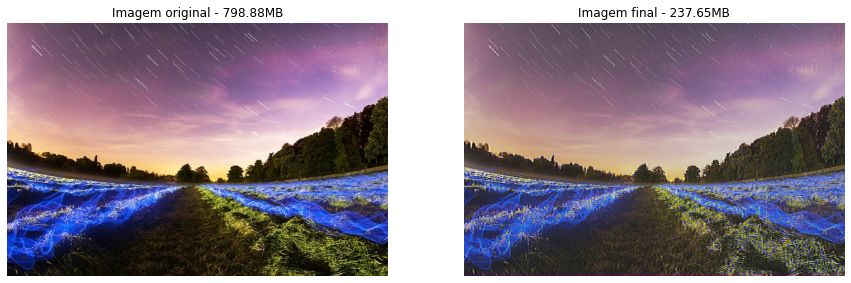

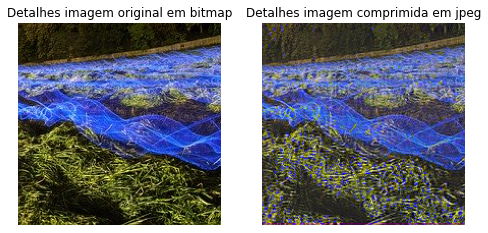

In [ ]:
nomeArquivoFinal = 'img.jpg'

arquivoJPEG = open(nomeArquivoFinal, 'wb+')
# Header JPEG
arquivoJPEG.write(huffman.hexToBytes('FFD8FFE000104A46494600010100000100010000'))
# Tabela de quantização da luminância
arquivoJPEG.write(huffman.hexToBytes('FFDB004300'))
vetorLuminancia = novaMatrizY.reshape([64])
arquivoJPEG.write(bytes(vetorLuminancia.tolist()))
# Tabela de quantização da crominância
arquivoJPEG.write(huffman.hexToBytes('FFDB004301'))
vetorCrominancia = novaMatrizCbCr.reshape([64])
arquivoJPEG.write(bytes(vetorCrominancia.tolist()))

# Altura e largura da imagem
arquivoJPEG.write(huffman.hexToBytes('FFC0001108'))

alturaHex = hex(alturaImagem)[2:]   # O valor em HEX é dada como 0xXXXXXXX, é necessário pegar somente os valores após o 0x
while len(alturaHex) != 4:          # Adiciona 0s até ficar com 4 dígitos
  alturaHex = '0' + alturaHex
arquivoJPEG.write(huffman.hexToBytes(alturaHex))

larguraHex = hex(larguraImagem)[2:]
while len(larguraHex) != 4:
  larguraHex = '0' + larguraHex
arquivoJPEG.write(huffman.hexToBytes(larguraHex))

# Subamostragem -> 03   01 11 00   02 11 01   03 11 01
#      para 1:1    //   // 11 //   // // //   // // //    -> apesar de estar subamostrado, é usado o header de imagem sem subamostragem
#      para 1:2    //   // 21 //   // // //   // // //
#      para 1:4    //   // 22 //   // // //   // // //
arquivoJPEG.write(huffman.hexToBytes('03011100021101031101'))

# Tabela de Huffman
arquivoJPEG.write(huffman.hexToBytes('FFC401A20000000701010101010000000000000000040503020601000708090A0B0100020203010101010100000000000000010002030405060708090A0B1000020103030204020607030402060273010203110400052112314151061361227181143291A10715B14223C152D1E1331662F0247282F12543345392A2B26373C235442793A3B33617546474C3D2E2082683090A181984944546A4B456D355281AF2E3F3C4D4E4F465758595A5B5C5D5E5F566768696A6B6C6D6E6F637475767778797A7B7C7D7E7F738485868788898A8B8C8D8E8F82939495969798999A9B9C9D9E9F92A3A4A5A6A7A8A9AAABACADAEAFA110002020102030505040506040803036D0100021103042112314105511361220671819132A1B1F014C1D1E1234215526272F1332434438216925325A263B2C20773D235E2448317549308090A18192636451A2764745537F2A3B3C32829D3E3F38494A4B4C4D4E4F465758595A5B5C5D5E5F5465666768696A6B6C6D6E6F6475767778797A7B7C7D7E7F738485868788898A8B8C8D8E8F839495969798999A9B9C9D9E9F92A3A4A5A6A7A8A9AAABACADAEAFA'))
# SOS = Start of Scan
# yDC yAC cbDC cbAC crDC crAC
tamanhoSOS = sosBitStream.__len__()   # Tamanho de bits da imagem
completar = 8 - tamanhoSOS % 8        # Caso o tamanho não de uma quantidade inteira de bytes, completar com bits iguais a 1
if(completar!=0):
  sosBitStream.write(np.ones([completar]).tolist(),bool)

arquivoJPEG.write(bytes([255, 218, 0, 12, 3, 1, 0, 2, 17, 3, 17, 0, 63, 0])) # FF DA 00 0C 03 01 00 02 11 03 11 00 3F 00

# Imagem codificada
sosBytes = sosBitStream.read(bytes)
for i in range(len(sosBytes)):
  arquivoJPEG.write(bytes([sosBytes[i]]))
  if(sosBytes[i]==255):
    arquivoJPEG.write(bytes([0])) # FF para FF 00

# Final do arquivo
arquivoJPEG.write(bytes([255,217])) # FF D9
arquivoJPEG.close()


tamanhoInicial = os.path.getsize("img.bmp")
tamanhoFinal   = os.path.getsize("img.jpg")
prctReducao    = format(100 - ((tamanhoFinal/tamanhoInicial)*100),'.2f')

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Imagem original - '+format((tamanhoInicial/1024),'.2f')+'MB')
plt.axis('off')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Imagem final - '+format((tamanhoFinal/1024),'.2f')+'MB')
plt.axis('off')
plt.imshow(plt.imread(nomeArquivoFinal))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Detalhes imagem original em bitmap')
plt.axis('off')
plt.imshow(img)
plt.xlim(larguraImagem - 200,larguraImagem)
plt.ylim(alturaImagem,alturaImagem - 200)
plt.subplot(1,2,2)
plt.title('Detalhes imagem comprimida em jpeg')
plt.axis('off')
plt.imshow(plt.imread(nomeArquivoFinal))
plt.xlim(larguraImagem - 200,larguraImagem)
plt.ylim(alturaImagem,alturaImagem - 200);
print('Redução:',prctReducao,'%')

# Referências
1. COMPRESSÃO DE IMAGENS: PADRÃO JPEG. Disponível em: <https://www.lcs.poli.usp.br/~gstolfi/PPT/APTV0616.pdf>. Acesso em: 12 nov. 2022.

1.  *The Unreasonable Effectiveness of JPEG: A Signal Processing Approach*. Disponível em: <https://www.youtube.com/watch?v=0me3guauqOU>. Acesso em: 12 nov. 2022.

1.  Discrete Cosine Transform (DCT). Disponível em: <https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/transforms.html>. Acesso em: 12 nov. 2022. 

1.  Transformada discreta de cosseno. Disponível em: <https://pt.wikipedia.org/wiki/Transformada_discreta_de_cosseno>. Acesso em: 12 nov. 2022.

1.  *Color Sampling*. Disponível em: <https://youtu.be/32PPzwPjDZ8>. Acesso em: 12 nov. 2022.

1.  Algoritmo de huffman.Disponível em: <https://github.com/fangwei123456/python-jpeg-encoder/blob/d92dcf7718543d9f09c0df43bb7df2e6ada76394/huffmanEncode.py>. Acesso em: 12 nov. 2022.

1.  *JPEG File Interchange Format*. Disponível em: <https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format>. Acesso em: 12 nov. 2022.

1.  Multimedia Systems
Image compression *texto em itálico*. Disponível em: <https://webhome.cs.uvic.ca/~pan/csc461s06/8-image.pdf>. Acesso em: 12 nov. 2022.

1.  *Image Compression to Advanced Video Coding*. Disponível em: <https://www.globalspec.com/reference/39556/203279/appendix-b-huffman-tables-for-the-dc-and-ac-coefficients-of-the-jpeg-baseline-encoder>. Acesso em: 12 nov. 2022.

1. *Fast JPEG Huffman Table Restoring and Decoding for Embedded DSP Implementations*. Disponível em: <https://ieeexplore.ieee.org/document/5365034>. Acesso em: 12 nov. 2022.

1.  Disponível em: <https://github.com/sudhamshu091/>. Acesso em: 12 nov. 2022.Huffman-Encoding-Decoding-For-Image-Compression

1.  *What’s lost in JPEG?*.Disponível em: <https://towardsdatascience.com/whats-lost-in-jpeg-e5e6e80b1f94>. Acesso em: 12 nov. 2022.

1. Disponível em: <https://medium.com/@sddkal/chroma-subsampling-in-numpy-47bf2bb5af83>. Acesso em: 12 nov. 2022.

1. *How I Came Up with the Discrete Cosine Transform.* Disponível em: <https://www.cse.iitd.ac.in/~pkalra/col783-2017/DCT-History.pdf>. Acesso em: 12 nov. 2022.

1.  *Princípios de Compressão - Redundância de Dados*. Disponível em: <http://www.institutopoincare.com.br/site/index.php?option=com_content&view=article&id=25:compressao-de-imagens-jpeg&catid=8&Itemid=126>. Acesso em: 12 nov. 2022.

1. *YCbCr*. Disponível em: <https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion>. Acesso em: 12 nov. 2022.

1.  *Everything You Need to Know About JPEG Tutorial Series*. Disponível em: <https://www.youtube.com/playlist?list=PLpsTn9TA_Q8VMDyOPrDKmSJYt1DLgDZU4>. Acesso em: 12 nov. 2022.

1.  *Color Conversion*. Disponível em: <https://web.archive.org/web/20180421030430/http://www.equasys.de/colorconversion.html>. Acesso em: 12 nov. 2022.

1.  *CHROMA SUBSAMPLING TECHNIQUES*. Disponível em: <https://www.red.com/red-101/video-chroma-subsampling>. Acesso em: 12 nov. 2022.

1.  *Codificação de Huffman* .Disponível em: <https://www.youtube.com/watch?v=xQQt5myz00o>. Acesso em: 12 nov. 2022.

1. *JPEG - Idea and Practice: The Header Part*. Disponível em: <https://en.wikibooks.org/wiki/JPEG_-_Idea_and_Practice/The_header_part>. Acesso: 16 nov. 2022.

1. *JPEG: Syntax and Structure*. Disponível em: <https://en.wikipedia.org/wiki/JPEG#Syntax_and_structure>. Acesso: 16 nov. 2022.

1. *JPEG File Interchange Format*. Disponível em: <https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format>. Acesso: 16 nov. 2022.

1. *Jpeg Image Compression*. Disponível em: <https://webdocs.cs.ualberta.ca/~jag/courses/ImProc/lectures2001/lec26/Lec26jpegCompr.PDF>. Acesso: 16 nov. 2022.

1. *List of JPEG Markers*. Disponível em: <https://www.disktuna.com/list-of-jpeg-markers/>. Acesso: 16 nov. 2022.

1. *JPEG Marker*. Disponível em: <http://lad.dsc.ufcg.edu.br/multimidia/jpegmarker.pdf>. Acesso: 16 nov. 2022.

1. *Understanding and Writing Jpeg Decoder in Python*. Disponível em: <https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python>. Acesso: 16 nov. 2022.
